In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp

In [2]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [106]:
from deepmeg.preprocessing.transforms import zscore

dataset = EpochsDataset((X, Y), transform=zscore, target_transform=zscore, savepath='../datasets/simulated_sources')
dataset.save('../data/simulated_sources.pt')

In [3]:
dataset = EpochsDataset.load('../data/simulated_sources.pt')

In [4]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [5]:

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [6]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch


class TS(nn.Module):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.n_channels = n_channels
        self.n_times = n_times
        self.i = nn.Parameter(torch.empty(self.n_times, self.n_channels))
        # self.s = nn.Parameter(torch.empty(1, self.n_channels))
        self.b = nn.Parameter(torch.empty(1, self.n_times))
        self.reset_parameters()
        self.x_prev = 0

    def reset_parameters(self) -> None:
        init.uniform_(self.i, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        # init.uniform_(self.s, -0.01, 0.01)

    def forward(self, x):
        out = torch.zeros(x.shape[0], self.n_times)
        for i in range(self.n_times):
            timepoint = x[:, :, i]
            # print(timepoint.shape)
            # sp_filter = self.i[i]@self.s
            out[:, i] = self.i[i]@timepoint.T

        return out + self.b


X = torch.rand(70, 10, 100)
TS(10, 100)(X).shape

torch.Size([70, 100])

In [7]:
class TSUnmixer(BaseModel):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.unmixing_layer = TS(n_channels, n_times)

    def forward(self, x):
        return self.unmixing_layer(x)

In [9]:
model = TSUnmixer(
    n_channels=58,
    n_times=1000
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

# loss = torch.nn.BCEWithLogitsLoss()
loss = torch.nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    # metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        # L2Reg(
        #     [
        #         'unmixing_layer.weight'
        #     ], lambdas=.01
        # )
    ]
)

In [34]:
sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.4955   |    loss_val:  0.4936
Epoch 1:  loss_train:  0.4863   |    loss_val:  0.4898
Epoch 2:  loss_train:  0.4777   |    loss_val:  0.4860
Epoch 3:  loss_train:  0.4692   |    loss_val:  0.4823
Epoch 4:  loss_train:  0.4609   |    loss_val:  0.4786
Epoch 5:  loss_train:  0.4527   |    loss_val:  0.4749
Epoch 6:  loss_train:  0.4447   |    loss_val:  0.4714
Epoch 7:  loss_train:  0.4372   |    loss_val:  0.4680
Epoch 8:  loss_train:  0.4302   |    loss_val:  0.4648
Epoch 9:  loss_train:  0.4238   |    loss_val:  0.4618
Epoch 10: loss_train:  0.4180   |    loss_val:  0.4588
Epoch 11: loss_train:  0.4125   |    loss_val:  0.4558
Epoch 12: loss_train:  0.4074   |    loss_val:  0.4527
Epoch 13: loss_train:  0.4025   |    loss_val:  0.4494
Epoch 14: loss_train:  0.3978   |    loss_val:  0.4461
Epoch 15: loss_train:  0.3932   |    loss_val:  0.4426
Epoch 16: loss_train:  0.3886   |    loss_val:  0.4390
Epoch 17: loss_train:  0.3842   |    loss_val:  0.4354
Epoch 18: 

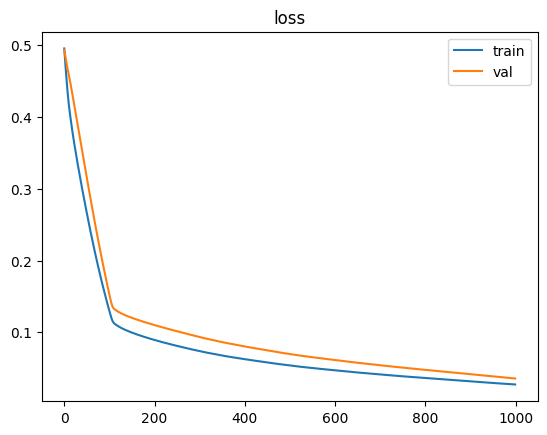

In [10]:
history = model.fit(train, n_epochs=1000, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [38]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.028472032770514487
loss: 0.035019130632281306


In [92]:
x_test, y_test = next(iter(DataLoader(test, len(test))))
y_pred = model(x_test).detach().numpy()


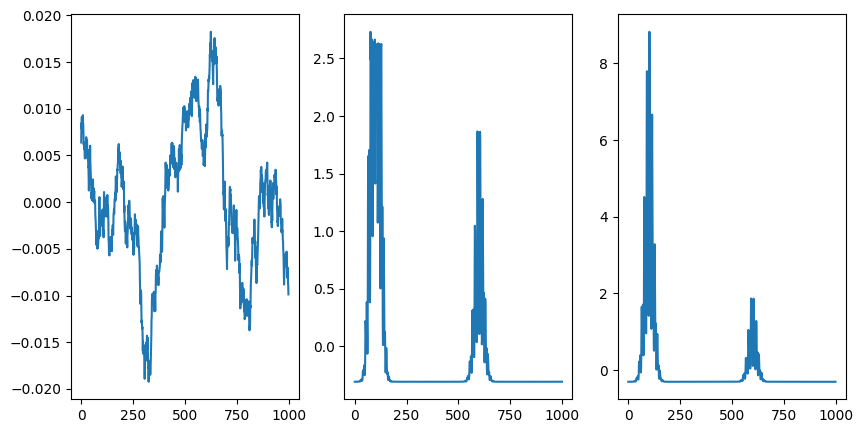

In [99]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test.mean((0,1)))
ax2.plot(y_pred.mean(0))
ax3.plot(y_test[i])

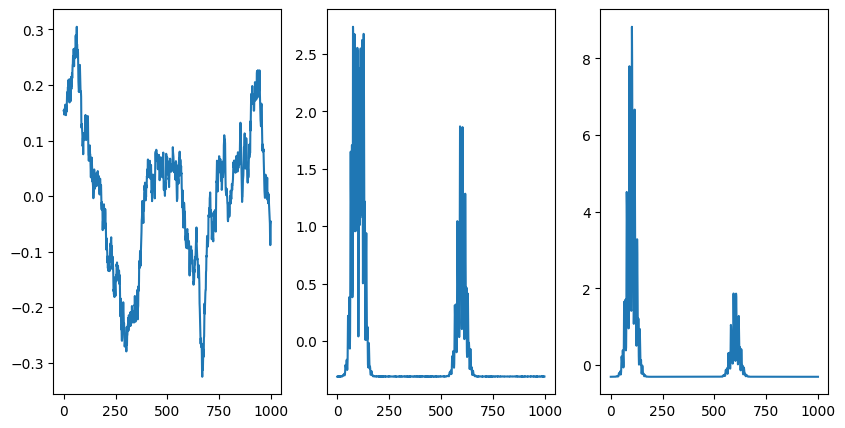

In [104]:
i = int(np.random.randint(len(y_pred)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.plot(x_test[i].mean((0)))
ax2.plot(y_pred[i])
ax3.plot(y_test[i])

In [151]:
w = model.unmixing_layer.i.detach().numpy()

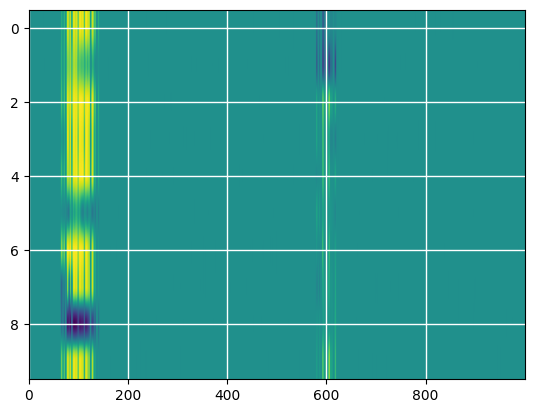

In [152]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.T, aspect='auto')
ax.grid(color='w', linewidth=1, which='both')

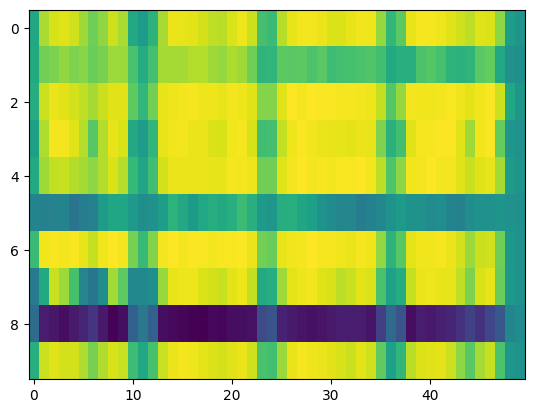

In [153]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.T[:, 75:125], aspect='auto')
# plt.pcolormesh(w.T, edgecolors='k', linewidth=2)

# ax.grid(color='w', linewidth=1, which='both')

In [126]:
for i, d in enumerate(distances):
    print(f'{i}: {d : .2f}')

0:  0.49
1:  0.03
2:  0.63
3:  0.40
4:  0.31
5:  0.00
6:  0.71
7:  0.50
8:  0.00
9:  0.44


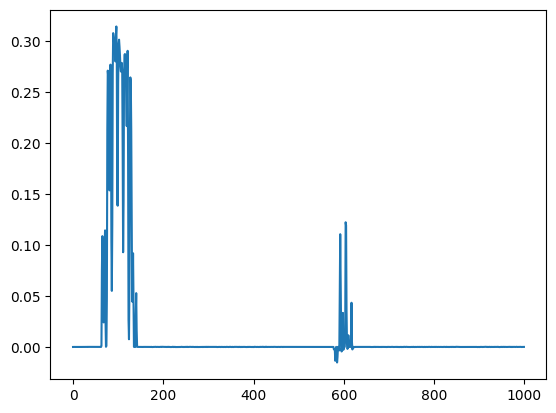

In [154]:
plt.plot(w.mean(1))

In [79]:
from collections import namedtuple

KeyResp = namedtuple('KeyResp', 'keys')
Text = namedtuple('Text', 'text')

text_12 = Text('Press J')
key_resp2 = KeyResp('f')

if (
    (
        key_resp2.keys == 'f' and text_12.text =='Press F'
    ) or (
        key_resp2.keys == 'j' and text_12.text =='Press J'
    )
):
    doleft, doright = 1, 0

elif (
    (
        key_resp2.keys == 'j' and text_12.text =='Press F'
    ) or (
        key_resp2.keys == 'f' and text_12.text =='Press J'
    )
):

    doleft, doright = 0, 1

doleft, doright

(0, 1)